In [8]:
import numpy as np
import pandas as pd
import os
import cv2

from typing import Optional, Union

import tensorflow as tf

In [18]:
class SqueezeNet:
    def __init__(self, inputDim: tuple):
        self.inputDim = inputDim
        
    def initModel(self):
        """
        Initializes the Model for training
        """
        input_, x = self._initTail()
        
        x = self._fireBlock(x, squeezeFilter=16, expandFilter=64)
        x = self._fireBlock(x, squeezeFilter=16, expandFilter=64)
        x = self._fireBlock(x, squeezeFilter=32, expandFilter=128)
        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

        x = self._fireBlock(x, squeezeFilter=32, expandFilter=128)
        x = self._fireBlock(x, squeezeFilter=48, expandFilter=192)
        x = self._fireBlock(x, squeezeFilter=48, expandFilter=192)
        x = self._fireBlock(x, squeezeFilter=64, expandFilter=256)
        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
        
        x = self._fireBlock(x, squeezeFilter=64, expandFilter=256)
        
        output_ = self._initHead(x)
        
        return tf.keras.Model(inputs=[input_], outputs=[output_])
        
    def _initTail(self):
        """
        Initialize the Input and Convolution part before that of fire blocks
        """
        self.input = tf.keras.layers.Input(self.inputDim)
        self.x = tf.keras.layers.Conv2D(96, 7, strides=2, padding='same', activation='relu')(self.input)
        self.x = tf.keras.layers.MaxPool2D(3, strides=2, padding='same')(self.x)
        
        return self.input, self.x
    
    def _fireBlock(self, x, squeezeFilter, expandFilter):
        """
        Initialize a Fire block
        """
        self.sq_out = tf.keras.layers.Conv2D(filters=squeezeFilter, kernel_size=1, activation='relu')(x)
        self.out_1x1 = tf.keras.layers.Conv2D(filters=expandFilter, kernel_size=1)(self.sq_out)
        self.out_3x3 = tf.keras.layers.Conv2D(filters=expandFilter, kernel_size=3, padding='same')(self.sq_out)
        
        self.concat = tf.keras.layers.Concatenate()([self.out_1x1, self.out_3x3])

        return tf.keras.layers.Activation('relu')(self.concat)
    
    def _initHead(self, x):
        """
        Initializes the part after the fire blocks
        """
        self.out = tf.keras.layers.Conv2D(1000, kernel_size=1)(x)
        self.out = tf.keras.layers.GlobalAveragePooling2D()(self.out)
        self.out = tf.keras.layers.Activation('softmax')(self.out)
        
        return self.out
    
    def fit(
        self, 
        X, 
        y, 
        nb_epochs: int = 10, 
        validation_data: Optional['tuple'] = None
    ):
        """
        Trains the SqueezeNet model
        """
        validation_data = validation_data if isinstance(validation_data, tuple) else None
        
        model = self.initModel()
        
        if validation_data is not None:
            hist = model.fit(
                X=X,
                y=y,
                epochs=nb_epochs,
                validation_data=validation_data
            )
        else:
            hist = model.fit(
                X=X,
                y=y,
                epochs=nb_epochs,
            )
        
        return hist

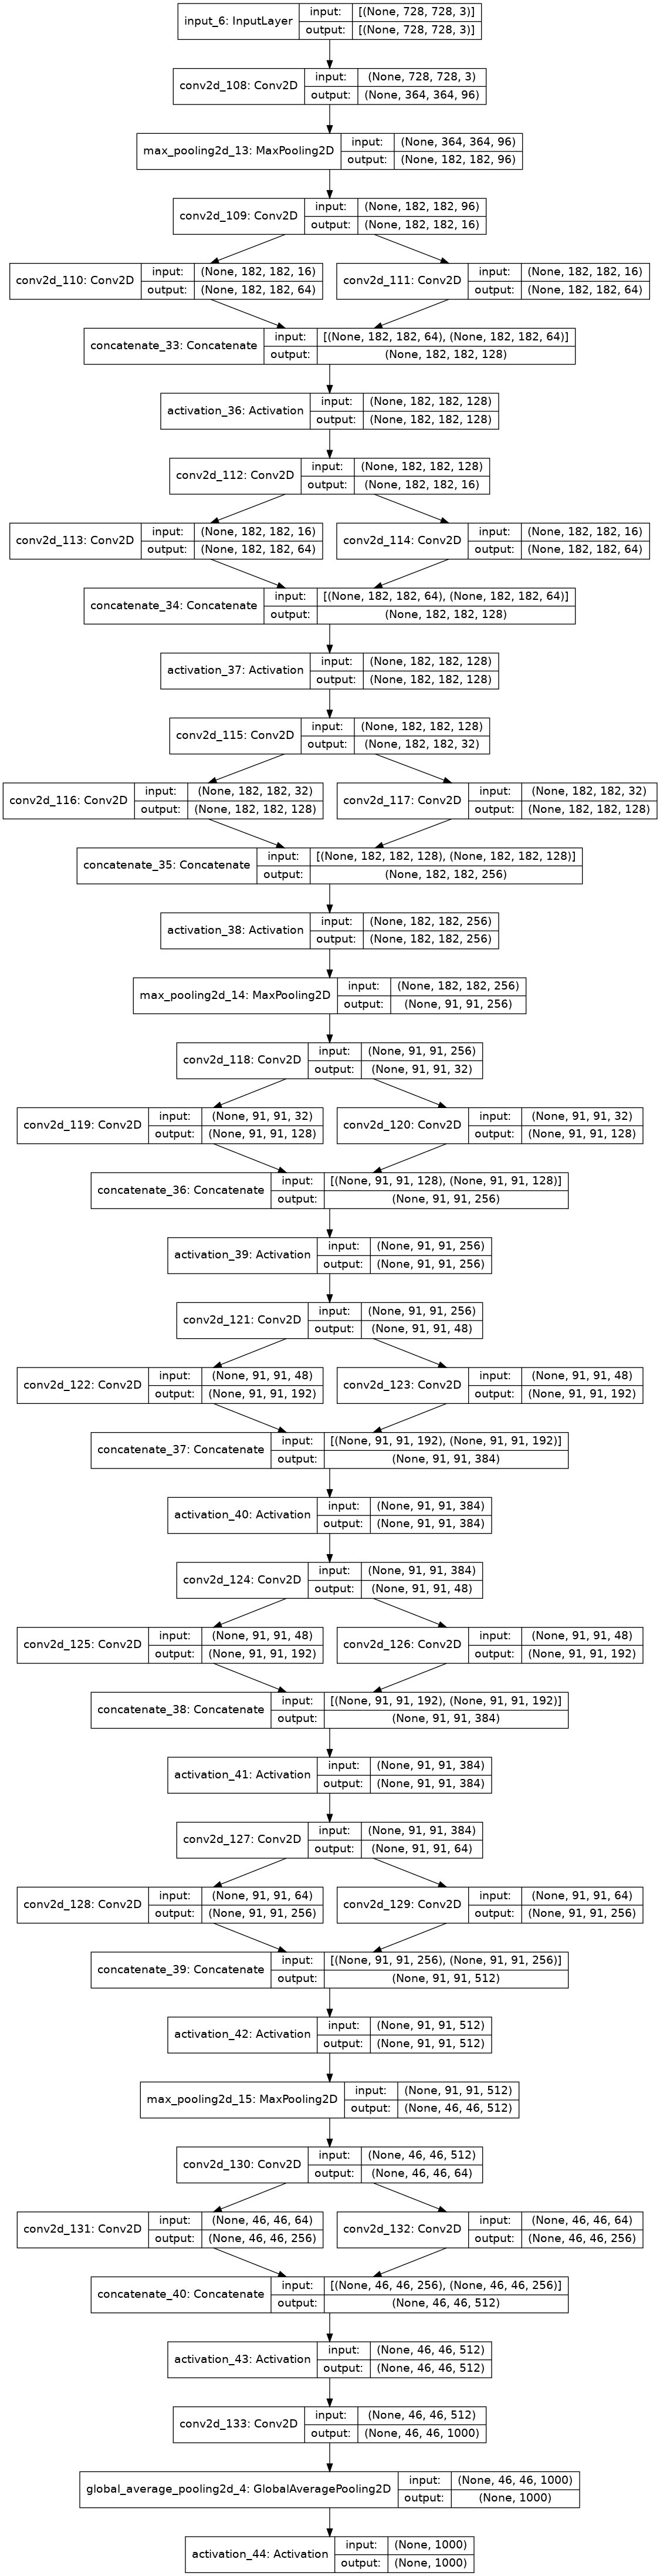

In [21]:
# Initialize the object and see the model architecture
sqnetModel = SqueezeNet(inputDim=[728, 728, 3])
model = sqnetModel.initModel()

tf.keras.utils.plot_model(model, show_shapes=True)